## 1. Setup and Load Data

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1.2 Load data

In [34]:
import cv2 as cv
import imghdr
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [35]:
data = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/receipt_model/original_dataset', batch_size=32, image_size=(256, 256))

Found 477 files belonging to 2 classes.


In [36]:
data_iter = data.as_numpy_iterator()

In [37]:
# Get another batch from the iterator
batch = data_iter.next()

In [38]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [39]:
# class labels 1 = printing, 0 = writting
batch[1]

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0], dtype=int32)

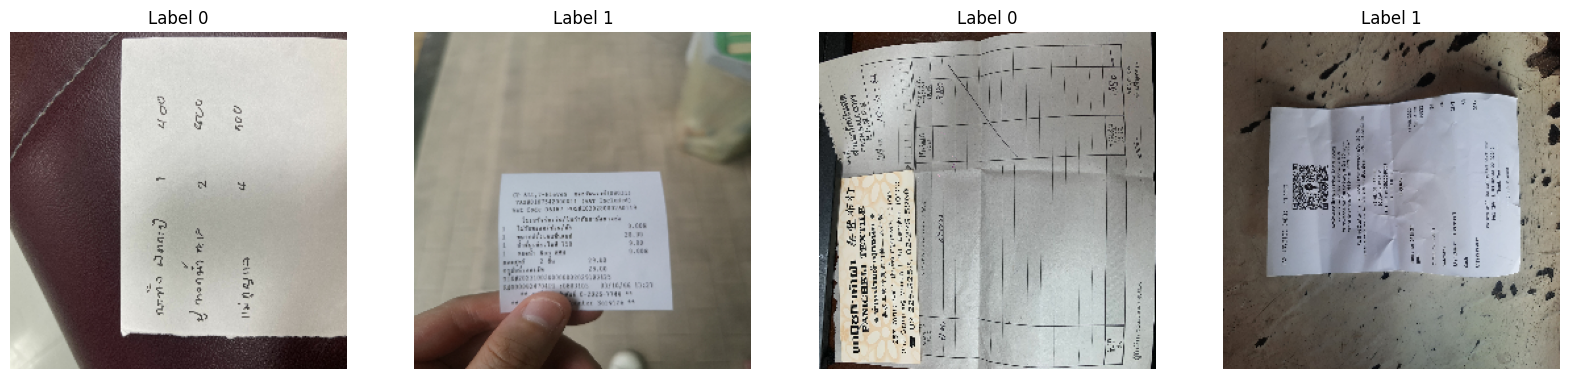

In [40]:
fix, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(np.uint8))
    ax[idx].axis('off')
    ax[idx].set_title('Label {}'.format(batch[1][idx]))

In [41]:
scaled = batch[0]/255

In [42]:
scaled.min(), scaled.max()

(0.0, 1.0)

## 2. Preprocessing Data

In [43]:
data = data.map(lambda x, y: (x/255, y))

In [44]:
scaled_iterator = data.as_numpy_iterator()

In [45]:
batch = scaled_iterator.next()

In [46]:
batch[0].min(), batch[0].max()

(0.0, 1.0)

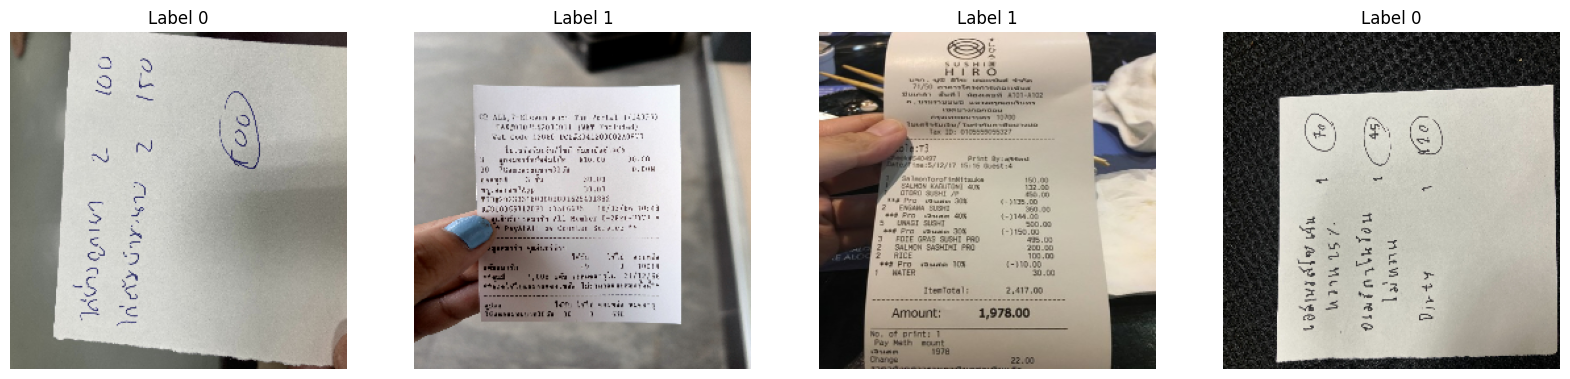

In [47]:
fix, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].axis('off')
    ax[idx].set_title('Label {}'.format(batch[1][idx]))

#### 2.2 Split Data

In [48]:
len(data)

15

In [49]:
train_size = int(len(data)* .8)
val_size = int(len(data)*.15)
test_size = int(len(data)*.1)

In [50]:
train_size, val_size, test_size

(12, 2, 1)

In [51]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [52]:
len(train), len(val), len(test)

(12, 2, 1)

## 3. Deep Model    

#### 3.1 Build Deep Learning Model

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import load_model

In [54]:
model_path = "/content/drive/MyDrive/receipt_model/models/CNN_ori_model_20epochs.h5"
model = load_model(model_path)

In [55]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

#### 3.2 Train

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

In [58]:
logdir = '/content/drive/MyDrive/receipt_model/logs'

In [59]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [60]:
history = model.fit(train, epochs=20, validation_data=val, callbacks=[EarlyStopping(monitor='val_loss', patience=3), tensorboard_callback])

Epoch 1/20
12/12 [==============================] - 43s 2s/step - loss: 0.1992 - accuracy: 0.9245 - val_loss: 0.0984 - val_accuracy: 0.9844
Epoch 2/20
12/12 [==============================] - 41s 3s/step - loss: 0.0797 - accuracy: 0.9792 - val_loss: 0.0222 - val_accuracy: 1.0000
Epoch 3/20
12/12 [==============================] - 38s 3s/step - loss: 0.0404 - accuracy: 0.9948 - val_loss: 0.0200 - val_accuracy: 1.0000
Epoch 4/20
12/12 [==============================] - 38s 2s/step - loss: 0.0737 - accuracy: 0.9661 - val_loss: 0.0311 - val_accuracy: 0.9844
Epoch 5/20
12/12 [==============================] - 40s 3s/step - loss: 0.0320 - accuracy: 0.9896 - val_loss: 0.0175 - val_accuracy: 1.0000
Epoch 6/20
12/12 [==============================] - 38s 3s/step - loss: 0.0150 - accuracy: 0.9974 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 7/20
12/12 [==============================] - 37s 2s/step - loss: 0.0184 - accuracy: 0.9922 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 8/20
12/12 [==

#### 3.3 Plot Performance

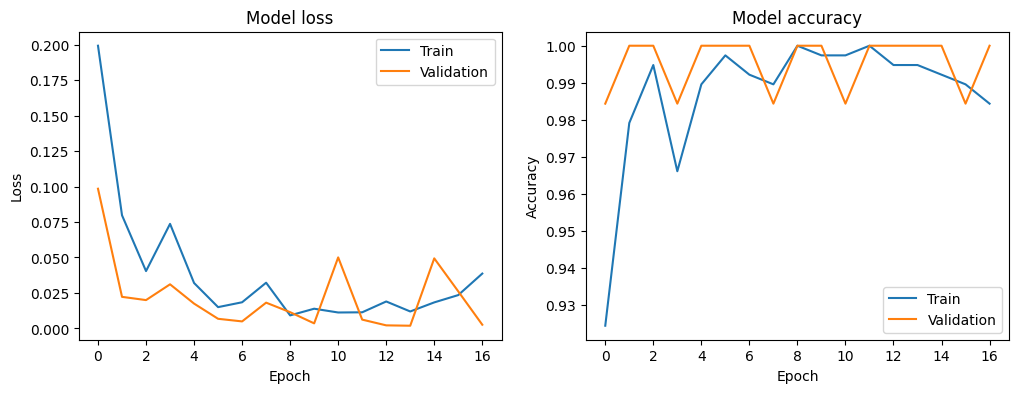

In [61]:
# Plot the training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation loss values
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training & validation accuracy values
ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Validation')
ax2.set_title('Model accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

## 4. Evaluation Performance

#### 4.1 Evaluate

In [62]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [63]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [64]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)
    acc.update_state(y, y_pred)

1/1 [==============================] - 0s 494ms/step


In [65]:
print('Precision: {}'.format(pre.result().numpy()))
print('Recall: {}'.format(rec.result().numpy()))
print('Accuracy: {}'.format(acc.result().numpy()))

Precision: 1.0
Recall: 1.0
Accuracy: 1.0


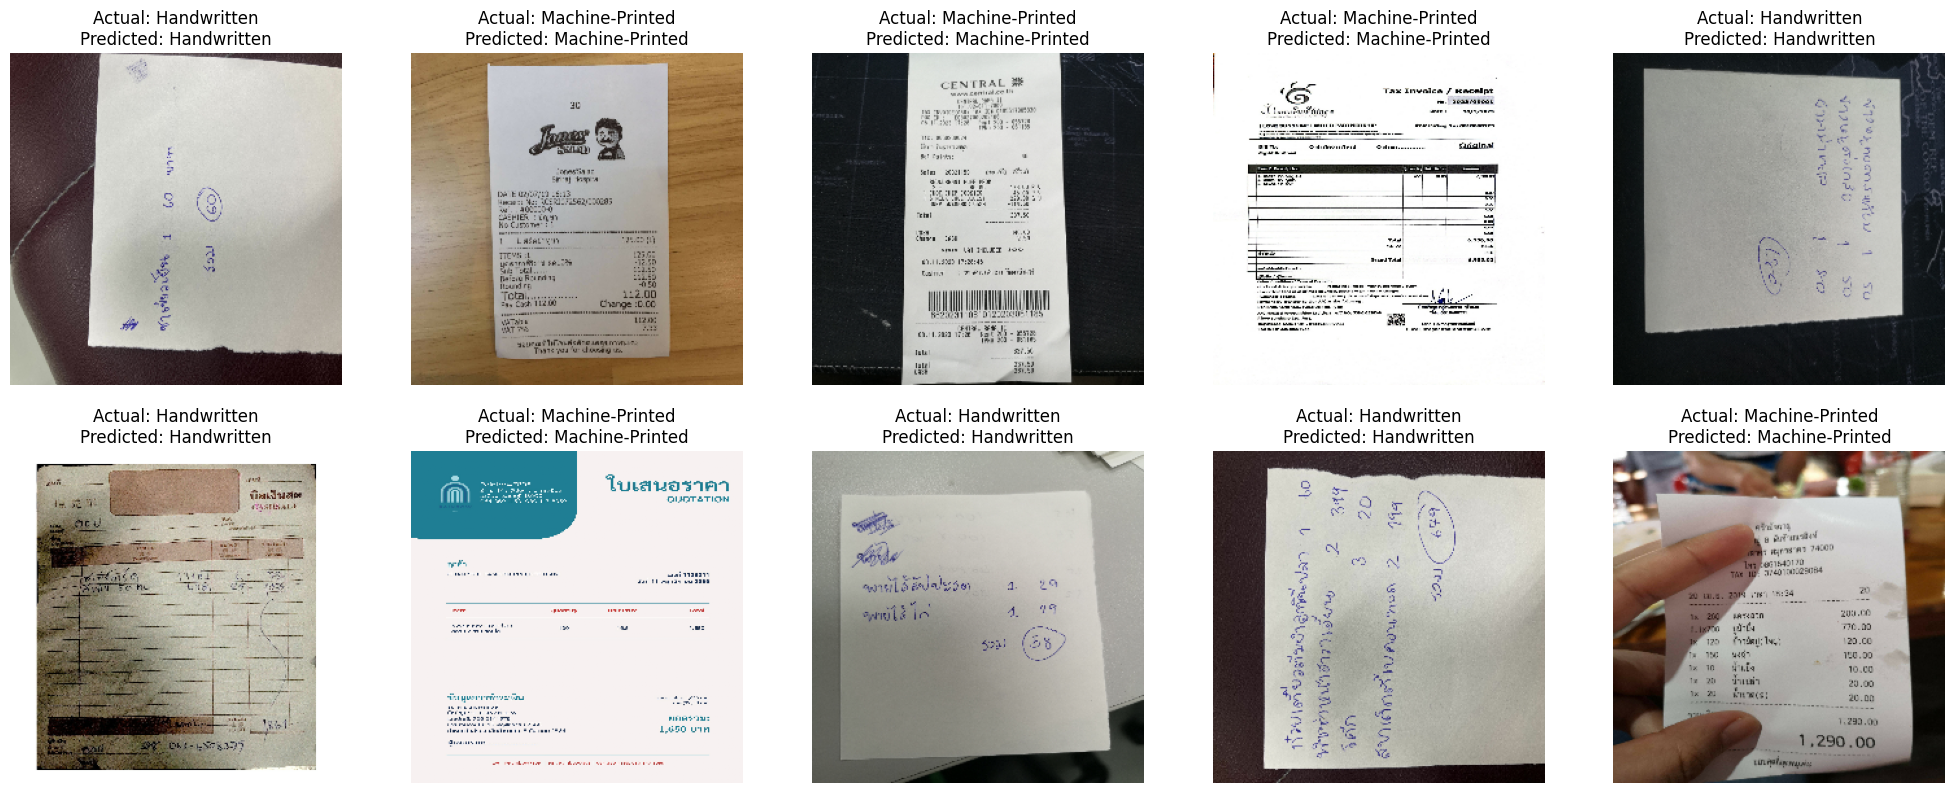

In [66]:
plt.figure(figsize=(25, 25))

for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X[i])
    actual_class = "Machine-Printed" if y[i] == 1 else "Handwritten"
    predicted_class = "Machine-Printed" if y_pred[i] > 0.5 else "Handwritten"
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class ))
    plt.axis("off")
plt.show()

In [67]:
for i in range(5):
    actual_class = "Machine-Printed" if y[i] == 1 else "Handwritten"
    predicted_class = "Machine-Printed" if y_pred[i] > 0.5 else "Handwritten"

    # Check if the actual and predicted classes are not equal (misclassification)
    if actual_class != predicted_class:
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i])
        plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class))
        plt.axis("off")

plt.show()

#### 4.2 Test

In [68]:
img_test1 = cv.imread('/content/drive/MyDrive/receipt_model/hand_test2.jpg')
img_test2 = cv.imread('/content/drive/MyDrive/receipt_model/print_test.jpg')

img_test1 = cv.cvtColor(img_test1, cv.COLOR_BGR2RGB)
img_test2 = cv.cvtColor(img_test2, cv.COLOR_BGR2RGB)

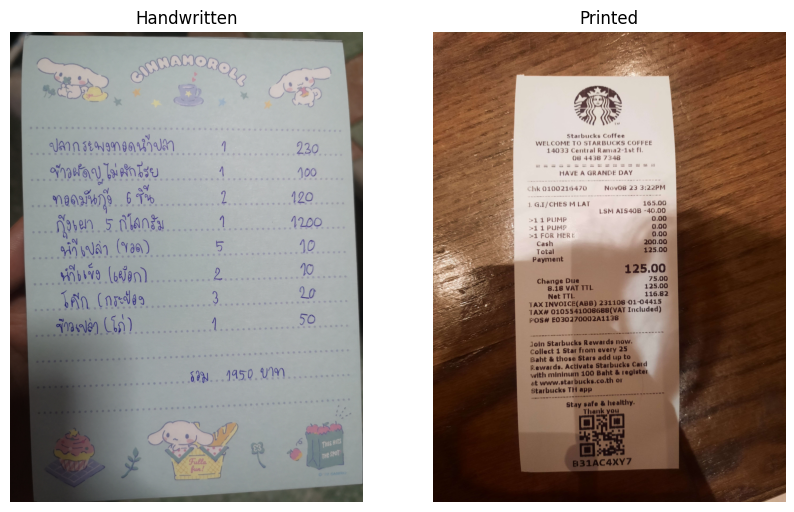

In [69]:
fx = plt.figure(figsize=(10, 10))
ax1 = fx.add_subplot(121)
ax1.imshow(img_test1)
ax1.axis('off')
ax1.set_title('Handwritten')

ax2 = fx.add_subplot(122)
ax2.imshow(img_test2)
ax2.axis('off')
ax2.set_title('Printed')

plt.show()

In [70]:
# Resize the images
img_resized1 = tf.image.resize(img_test1, (256, 256))
img_resized2 = tf.image.resize(img_test2, (256, 256))

# Clip the pixel values to the valid range
img_resized1 = img_resized1/255
img_resized2 = img_resized2 /255

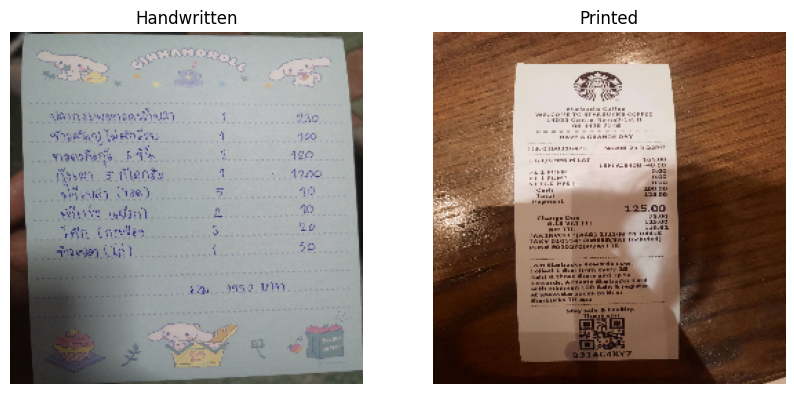

In [71]:
fx = plt.figure(figsize=(10, 10))
ax1 = fx.add_subplot(121)
ax1.imshow(img_resized1)
ax1.axis('off')
ax1.set_title('Handwritten')

ax2 = fx.add_subplot(122)
ax2.imshow(img_resized2)
ax2.axis('off')
ax2.set_title('Printed')

plt.show()

In [72]:
def prediction(model, img):
  y_pred = model.predict(np.expand_dims(img, axis=0))
  if y_pred[0][0] > 0.5:
    return 'Machine-Printed'
  else:
    return 'Handwritten'

1/1 [==============================] - 0s 19ms/step


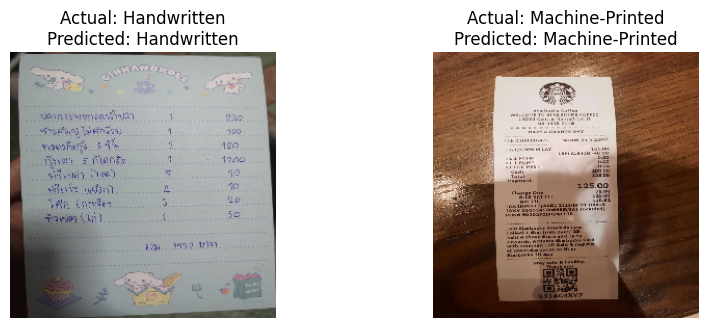

In [73]:
plt.figure(figsize=(10, 20))

# Assuming img_resized1 and img_resized2 are TensorFlow tensors
# Convert them to NumPy arrays for display
images = {'Handwritten': np.array(img_resized1), 'Machine-Printed': np.array(img_resized2)}

for i, (class_label, img) in enumerate(images.items()):
    plt.subplot(5, 2, i + 1)  # Assuming you want 2 images per row

    plt.imshow(img)
    predicted_class = prediction(model, img)
    plt.title("Actual: {}\nPredicted: {}".format(class_label, predicted_class))
    plt.axis("off")

plt.show()
